# Overview

This project represents an attempt to utilize machine learning and natural language processing techniques to predict NPS sentiments (Promotor, Passive, Detractor) based on surveys submitted through the NPS system. 

Author: Eric G. Suchanek, PhD for BestBuy.


Methods tried: 
* Sentiment analysis using textblob
* RNN
* LSTM
* BERT
* BoW

The following directory structure must be maintained:  
* main directory/
* notebook/  <-- where this notebook resides
    --data/
    -- raw/
    -- clean/
    -- pass/
    -- prom/
    -- det/

Based on: https://erleem.medium.com/nlp-complete-sentiment-analysis-on-amazon-reviews-374e4fea9976

(c) 2022 BestBuy, all rights reserved. Confidential. Do not share.

# Imports

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [1]:
import re
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
import pickle

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

from keras.preprocessing.text import text_to_word_sequence

import datetime
from bby import util
from bby.util import lemma_remove_stopwords
from bby.util import sent_to_words, get_wordnet_pos


# Data importing and exploration

In [2]:
NPS_df = pd.read_csv('../data/clean/NPS_NATL_subset.csv')
NPS_df.head(5)

,Unnamed: 0,Location,Workforce,NPS® Breakdown,NPS_Code,NPSCommentLemmatised,OverallCommentLemmatised
0,0,1031,Precinct,Promoter,2,Easy fix,purchase replacement battery laptop third part...
1,1,268,Precinct,Promoter,2,excellent service render,NONE
2,2,558,Precinct,Promoter,2,technician excellent courteous knowledgeable r...,Excellent
3,3,445,Precinct,Promoter,2,like bring computer free tuneup every 3 month,NONE
4,4,1252,Precinct,Promoter,2,Taylor team take professional contact promptly...,Thanks Taylor team geek squad ery professional


In [3]:
#Let's get the dataset lenght
len(NPS_df)

24769

In [4]:
#How's distributed the dataset? Is it biased?
NPS_df.groupby('NPS® Breakdown').nunique()

,Unnamed: 0,Location,Workforce,NPS_Code,NPSCommentLemmatised,OverallCommentLemmatised
NPS® Breakdown,,,,,,
Detractor,8349,929,2,1,7449,5651
Passive,8164,927,2,1,5492,3639
Promoter,8256,929,2,1,5810,3597


<BarContainer object of 3 artists>

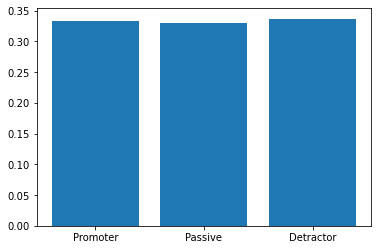

In [5]:
#Checking balance of target classes
sentiments = list(NPS_df["NPS® Breakdown"].unique())

sentiment_nums = [len(NPS_df[NPS_df["NPS® Breakdown"] == sentiment]) / len(NPS_df) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)

# Data cleaning


In [10]:
# testing
import bby
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


def lemma_remove_stopwords2(_ls):
    # Lemmatises, then removes stop words
    lemmatiser = WordNetLemmatizer()
    porter = PorterStemmer()
    ls = str(_ls)
    
    stop_english = Counter(stopwords.words()) # Here we use a Counter dictionary on the cached
                                            # list of stop words for a huge speed-up
    result = ls.translate(str.maketrans('', '', string.punctuation)) #removes [!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]:

    word_tokens = word_tokenize(result)
    # print(word_tokens)
    filtered_sentence = [porter.stem(w) for w in word_tokens if not w.lower() in stop_english]

    ls = [lemmatiser.lemmatize(word, get_wordnet_pos(word)) for word in filtered_sentence]

    #Joins the words back into a single string
    ls = " ".join(ls)
    return ls


In [11]:
# grab the NPS and NPS overall comments for all stores

#overall_list = NPS_df['OverallCommentLemmatised'].apply(lemma_remove_stopwords)
nps_list = NPS_df['NPSCommentLemmatised'].apply(lemma_remove_stopwords2)


In [12]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()
words = ['Connects','Connecting','Connections','Connected','Connection','Connectings','Connect']
wordlist = []
for word in words:
    print(word,"--->",porter.stem(word))

test = ['he brings the hugely huge hungers greatest connects connections connected big bigger biggest service services servicing']


res = lemma_remove_stopwords2(test)
print(res)

res = lemma_remove_stopwords(test)
print(res)


Connects ---> connect
Connecting ---> connect
Connections ---> connect
Connected ---> connect
Connection ---> connect
Connectings ---> connect
Connect ---> connect
bring huge huge hunger great connect connect connect big big big servic servic servic
brings hugely huge hunger great connects connection connect big big big service service service


In [70]:

# grab the lemmatised overall NPS comments
nps_list2 = list(nps_list.values)
data_words = list(sent_to_words(nps_list2))
len(data_words)

def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)
data = []

for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['tech gavin extrem knowledg patient help', 'friendli knoleg quick', 'help beyond randon total awesom', 'quick reliabl advic give comput purchas', 'friendli staff fast servic']


# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Detractor, Passive and Promoter to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [10]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
NPS_df['code'] = LE.fit_transform(NPS_df['NPS® Breakdown'])
NPS_df.head()

,Location,Workforce,NPS® Breakdown,NPS_Code,NPSCommentLemmatised,OverallCommentLemmatised,code
0,871,Precinct,Promoter,2,always gotten jam anything brought HiTech nature,NONE,2
1,462,Precinct,Promoter,2,receive great service,comment,2
2,414,Autotech,Promoter,2,service amaze,NONE,2
3,279,Precinct,Promoter,2,like service lot,Glad around save headache,2
4,1400,Precinct,Promoter,2,helpful store actually talk person store phone,NONE,2


In [11]:
labels = np.array(NPS_df['NPS® Breakdown'])
y = []
for i in labels:
    if i == 'Promoter':
        y.append(2.0)
    elif i == 'Passive':
        y.append(1.0)
    elif i == 'Detractor':
        y.append(0.0)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y
print(len(labels))

20496


# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [12]:
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Conv2D
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Bidirectional

max_words = 20000
# was 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
comments = pad_sequences(sequences, maxlen=max_len)

In [13]:
#
#  use scikit-multilearn since we are using a non-binary (trinary output)
import skmultilearn
from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_test, y_test = iterative_train_test_split(comments, labels, test_size = 0.2)


In [14]:
from keras.backend import clear_session
# Before instantiating a tf.data.Dataset obj & before model creation, call:
clear_session()

# Model building

In the next cells we experiment with several different Neural Networks. I'll implement sequential models from the Keras API to achieve this task. Essentially, I'll start with a single layer **LSTM** network which is known by achieving good results in NLP tasks when the dataset is relatively small (I could have started with a SimpleRNN which is even simpler, but to be honest it's actually not deployed in production environments because it is too simple - however I'll leave it commented in case you want to know it's built). The next one will be a Bidirectional LSTM model, a more complex one and this particular one is known to achieve great metrics when talking about text classification. To go beyond the classic NLP approach, finally we'll implement a very unusual model: a Convolutional 1D network, known as well by delivering good metrics when talking about NLP. If everything goes ok, we should get the best results with the BidRNN, let's see what happens.


## SimpleRNN model (Bonus)

In [ ]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3,activation='softmax'))

log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

metric = 'val_accuracy'
model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1, save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint0, tensorboard_callback])

In [ ]:
# plot learning curves
import matplotlib.pyplot as pyplot

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Single LSTM layer model

In [15]:
model1 = Sequential()
model1.add(Embedding(max_words, 20))
model1.add(LSTM(15,dropout=0.25)) # was .5
model1.add(Dense(3,activation='softmax'))

log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test),callbacks=[checkpoint1, tensorboard_callback])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-16 14:42:45.551652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-16 14:42:45.551788: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2022-05-16 14:42:45.761639: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-16 14:42:46.595860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 14:42:46.775496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 14:42:47.096649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - ETA: 0s - loss: 0.8737 - accuracy: 0.5920

2022-05-16 14:43:26.300294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 14:43:26.347973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - 44s 83ms/step - loss: 0.8737 - accuracy: 0.5920 - val_loss: 0.7813 - val_accuracy: 0.6323
Epoch 2/50
513/513 [==============================] - 36s 70ms/step - loss: 0.7466 - accuracy: 0.6623 - val_loss: 0.7423 - val_accuracy: 0.6654
Epoch 3/50
513/513 [==============================] - 36s 70ms/step - loss: 0.7078 - accuracy: 0.6819 - val_loss: 0.7168 - val_accuracy: 0.6735
Epoch 4/50
513/513 [==============================] - 36s 71ms/step - loss: 0.6854 - accuracy: 0.6963 - val_loss: 0.7087 - val_accuracy: 0.6891
Epoch 5/50
513/513 [==============================] - 36s 70ms/step - loss: 0.6732 - accuracy: 0.7019 - val_loss: 0.7079 - val_accuracy: 0.6903
Epoch 6/50
513/513 [==============================] - 35s 69ms/step - loss: 0.6650 - accuracy: 0.7080 - val_loss: 0.7076 - val_accuracy: 0.6894
Epoch 7/50
513/513 [==============================] - 36s 70ms/step - loss: 0.6569 - accuracy: 0.7108 - val_loss: 0.7051 - val_accuracy: 0.6881
Epo

In [16]:
# this is generally about the best model so far 5/16/22
model1b = Sequential()
model1b.add(Embedding(max_words, 20))
model1b.add(LSTM(25,dropout=0.4))
model1b.add(Dense(10,activation='tanh'))
model1b.add(Dense(3,activation='softmax'))

log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model1b.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint4 = ModelCheckpoint("best_model1b.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model1b.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test),callbacks=[checkpoint4, tensorboard_callback])

Epoch 1/50


2022-05-16 15:46:05.470415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 15:46:05.662865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 15:46:05.950742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - ETA: 0s - loss: 0.8650 - accuracy: 0.5867

2022-05-16 15:46:43.568620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 15:46:43.620231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - 43s 79ms/step - loss: 0.8650 - accuracy: 0.5867 - val_loss: 0.7853 - val_accuracy: 0.6266
Epoch 2/50
513/513 [==============================] - 35s 68ms/step - loss: 0.7484 - accuracy: 0.6583 - val_loss: 0.7449 - val_accuracy: 0.6642
Epoch 3/50
513/513 [==============================] - 34s 66ms/step - loss: 0.7219 - accuracy: 0.6773 - val_loss: 0.7325 - val_accuracy: 0.6684
Epoch 4/50
513/513 [==============================] - 34s 66ms/step - loss: 0.7005 - accuracy: 0.6895 - val_loss: 0.7160 - val_accuracy: 0.6867
Epoch 5/50
513/513 [==============================] - 34s 66ms/step - loss: 0.6849 - accuracy: 0.6981 - val_loss: 0.7174 - val_accuracy: 0.6720
Epoch 6/50
513/513 [==============================] - 34s 66ms/step - loss: 0.6919 - accuracy: 0.6977 - val_loss: 0.7085 - val_accuracy: 0.6850
Epoch 7/50
513/513 [==============================] - 34s 66ms/step - loss: 0.6693 - accuracy: 0.7051 - val_loss: 0.7084 - val_accuracy: 0.6842
Epo

In [17]:
model1c = Sequential()
model1c.add(Embedding(max_words, 100))
model1c.add(LSTM(25,dropout=0.4))
model1c.add(Dense(10,activation='relu'))
model1c.add(Dense(3,activation='softmax'))

log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model1c.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint5 = ModelCheckpoint("best_model1c.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model1c.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test),callbacks=[checkpoint5, tensorboard_callback])

Epoch 1/50


2022-05-16 16:14:31.948917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 16:14:32.152792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 16:14:32.440761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - ETA: 0s - loss: 0.8298 - accuracy: 0.6177

2022-05-16 16:15:14.530376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 16:15:14.583967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - 47s 88ms/step - loss: 0.8298 - accuracy: 0.6177 - val_loss: 0.7509 - val_accuracy: 0.6657
Epoch 2/50
513/513 [==============================] - 38s 74ms/step - loss: 0.7079 - accuracy: 0.6842 - val_loss: 0.7150 - val_accuracy: 0.6803
Epoch 3/50
513/513 [==============================] - 38s 74ms/step - loss: 0.6786 - accuracy: 0.6990 - val_loss: 0.7146 - val_accuracy: 0.6847
Epoch 4/50
513/513 [==============================] - 37s 72ms/step - loss: 0.6616 - accuracy: 0.7132 - val_loss: 0.7073 - val_accuracy: 0.6903
Epoch 5/50
513/513 [==============================] - 36s 71ms/step - loss: 0.6509 - accuracy: 0.7158 - val_loss: 0.7197 - val_accuracy: 0.6742
Epoch 6/50
513/513 [==============================] - 35s 68ms/step - loss: 0.6416 - accuracy: 0.7198 - val_loss: 0.7065 - val_accuracy: 0.6837
Epoch 7/50
513/513 [==============================] - 34s 67ms/step - loss: 0.6342 - accuracy: 0.7245 - val_loss: 0.7094 - val_accuracy: 0.6852
Epo

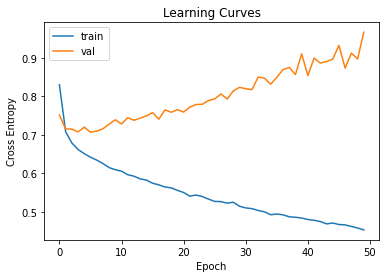

In [18]:
# plot learning curves
import matplotlib.pyplot as pyplot

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Bidirectional LTSM model

In [19]:
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model2 = Sequential()
model2.add(Embedding(max_words, 100, input_length=max_len))
model2.add(Bidirectional(LSTM(20,dropout=0.6)))
model2.add(Dense(10,activation='sigmoid'))
model2.add(Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint2, tensorboard_callback])

Epoch 1/50


2022-05-16 16:44:17.647553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 16:44:18.038447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 16:44:18.049990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 16:44:18.508563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 16:44:18.524067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - ETA: 0s - loss: 0.8928 - accuracy: 0.5832

2022-05-16 16:45:20.030548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 16:45:20.119311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 16:45:20.127412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - 71s 131ms/step - loss: 0.8928 - accuracy: 0.5832 - val_loss: 0.7905 - val_accuracy: 0.6357
Epoch 2/50
513/513 [==============================] - 59s 114ms/step - loss: 0.7577 - accuracy: 0.6597 - val_loss: 0.7526 - val_accuracy: 0.6569
Epoch 3/50
513/513 [==============================] - 58s 113ms/step - loss: 0.7211 - accuracy: 0.6762 - val_loss: 0.7254 - val_accuracy: 0.6786
Epoch 4/50
513/513 [==============================] - 57s 110ms/step - loss: 0.6993 - accuracy: 0.6937 - val_loss: 0.7211 - val_accuracy: 0.6808
Epoch 5/50
513/513 [==============================] - 56s 110ms/step - loss: 0.6870 - accuracy: 0.6972 - val_loss: 0.7239 - val_accuracy: 0.6725
Epoch 6/50
513/513 [==============================] - 56s 109ms/step - loss: 0.6737 - accuracy: 0.7069 - val_loss: 0.7075 - val_accuracy: 0.6862
Epoch 7/50
513/513 [==============================] - 56s 110ms/step - loss: 0.6633 - accuracy: 0.7089 - val_loss: 0.7107 - val_accuracy: 0.6

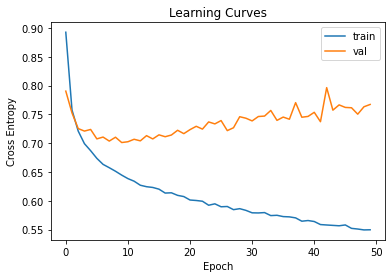

In [20]:
# plot learning curves

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## 1D Convolutional model

Before diving into this model, I know by prior experience that it tends to overfit extremely fast on small datasets. In this sense, just will implement it to show you how to do it in case it's of your interest.

In [ ]:
# 
from keras import regularizers
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model3 = Sequential()
model3.add(layers.Embedding(max_words, 100, input_length=max_len)) # was 40
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),callbacks=[checkpoint3, tensorboard_callback])

In [ ]:
# plot learning curves
import matplotlib.pyplot as pyplot

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

If you check the val_accuracy metric in the training logs you won't find better score than the one achieved by the BidRNN. Again, the previous model is not the best for this task becaue is majorly used for short translation tasks, but the good thing to notice is its speed to train.

Let's move on.

# Best model validation
(Before final commit, the best model obtained was the BidRNN)

In [ ]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model4.hdf5")

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

In [ ]:
predictions = best_model.predict(X_test)

## Confusion matrix

Alright, we all know the accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, that way I have a better understanding of its classification and generalization ability. Let's plot it.

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Detractor','Passive','Promoter'],columns = ['Detractor','Passive','Promoter'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Again, the model's score is very poor, but keep in mind it hasn't gone through hyperparameter tuning. Let's see how it performs on some test text.

In [ ]:
sentiment = ['Detractor','Passive','Promoter']
def predict_nps(input_sentence):
    sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
    test = pad_sequences(sequence, maxlen=max_len)
    print(f'{input_sentence} - {sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]}')
    return




In [ ]:
predict_nps('Eric Suchanek is the best agent ever!')
predict_nps('i hate youtube ads, they are annoying')

In [ ]:
sequence = tokenizer.texts_to_sequences(['Eric Suchanek is the best agent ever!'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

In [ ]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

In [ ]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]